In [89]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import KMeans
from datetime import datetime, timedelta, date
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [90]:
# Read the data
customer = pd.read_csv('customer_segmentation.csv')
customer.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Feature Engineering

In [91]:
# Convert the InvoiceDate to datetime
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'])

In [92]:
# Create YearMonth field for the ease of reporting and visualization
customer['InvoiceYearMonth'] = customer['InvoiceDate'].map(lambda date: 100*date.year + date.month)
customer.describe()

,index,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,270954.000000,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,0.000000,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,135477.000000,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,270954.000000,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,406431.000000,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,541908.000000,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,156435.797851,218.081158,NaN,96.759853,1713.600303,25.788703


In [93]:
# Check the contents of the "Country" column
customer["Country"].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [94]:
# Use only Australia data
customer_aus = customer[customer["Country"] == "Australia"].reset_index(drop=True)
customer_aus.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia,201012
1,198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia,201012
2,199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia,201012
3,200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia,201012
4,201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,2010-12-01 10:03:00,6.35,12431.0,Australia,201012


In [95]:
# Check for null values
customer_aus.isnull().sum()

index               0
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
InvoiceYearMonth    0
dtype: int64

# Segmentation Techniques

Implement the RFM (Recency - Frequency - Monetary Value) Technique
1. Low Value - Less active customers
2. Mid Value - Fairly active customers
3. High Value - Most Active customers

## 1. Recency - The fact of being recent, of having occurred a relatively short time ago.
- Calculated by finding the most recent purchase date of each customer and find out the number of active days.
- K-means clusturing is applied to find the recency score

In [96]:
# Create a dataframe to keep customerID and new segmentation scores
customer_segmentation = customer_aus[['CustomerID']].drop_duplicates()
customer_segmentation

,CustomerID
0,12431.0
14,12386.0
22,12434.0
35,12415.0
84,12393.0
106,12388.0
125,12422.0
138,16321.0
642,12424.0


In [97]:
# Find out the last time the customer made a purchase
last_purchase = customer_aus.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase.head()

,CustomerID,LastPurchaseDate
0,12386.0,2011-01-06 12:37:00
1,12388.0,2011-11-24 12:30:00
2,12393.0,2011-09-28 15:41:00
3,12415.0,2011-11-15 14:22:00
4,12422.0,2011-09-05 09:48:00


In [98]:
# Calculate recency
last_purchase['Recency'] = (last_purchase['LastPurchaseDate'].max() - last_purchase['LastPurchaseDate']).dt.days
last_purchase.head()

,CustomerID,LastPurchaseDate,Recency
0,12386.0,2011-01-06 12:37:00,321
1,12388.0,2011-11-24 12:30:00,0
2,12393.0,2011-09-28 15:41:00,56
3,12415.0,2011-11-15 14:22:00,8
4,12422.0,2011-09-05 09:48:00,80


In [99]:
# Merge the dataframes
customer_segmentation = pd.merge(customer_segmentation, last_purchase[['CustomerID', 'Recency']], on='CustomerID')
customer_segmentation.head()

,CustomerID,Recency
0,12431.0,20
1,12386.0,321
2,12434.0,68
3,12415.0,8
4,12393.0,56


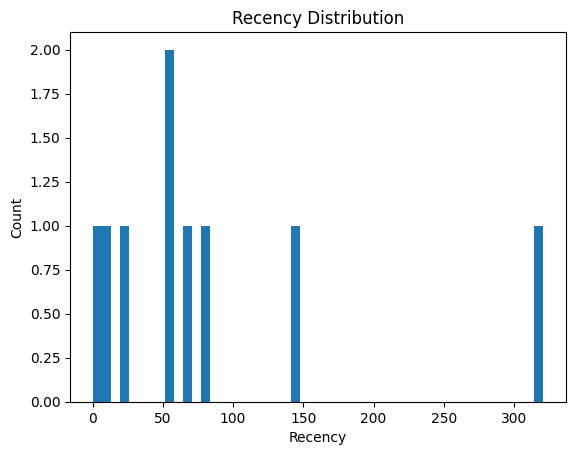

In [100]:
# Check the distribution of Recency
plt.hist(customer_segmentation['Recency'], bins=50)
plt.xlabel('Recency')
plt.ylabel('Count')
plt.title('Recency Distribution')
plt.show()

## Assign Recency Score
Apply K-means clustering to assign recency score by telling how many clusters we need to assign to K-means algorithm. Apply Elbow Method -  tells the optimal cluster number for optimal inertia.

c:\Users\Langat Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


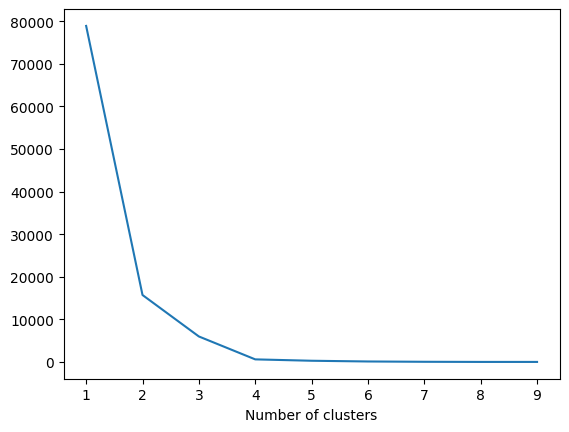

In [101]:
# Assign recency score using elbow method
sse = {}
recency = customer_segmentation[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [102]:
# Build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_segmentation[['Recency']])
customer_segmentation['RecencyCluster'] = kmeans.predict(customer_segmentation[['Recency']])
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster
0,12431.0,20,2
1,12386.0,321,1
2,12434.0,68,0
3,12415.0,8,2
4,12393.0,56,0


In [103]:
customer_segmentation.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5.0,81.400000,37.997368,56.0,56.0,68.0,80.0,147.0
1,1.0,321.000000,NaN,321.0,321.0,321.0,321.0,321.0
2,3.0,9.333333,10.066446,0.0,4.0,8.0,14.0,20.0


## Ordering Clusters

In [104]:
# Function to order the cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

customer_segmentation.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,5.0,81.400000,37.997368,56.0,56.0,68.0,80.0,147.0
1,1.0,321.000000,NaN,321.0,321.0,321.0,321.0,321.0
2,3.0,9.333333,10.066446,0.0,4.0,8.0,14.0,20.0


## Frequency
How often the customer makes purchase

In [105]:
# Get order counts for each customer and create a dataframe with it
order_data = customer_aus.groupby('CustomerID').InvoiceDate.count().reset_index()
order_data.columns = ['CustomerID', 'Frequency']
order_data.head()

,CustomerID,Frequency
0,12386.0,10
1,12388.0,100
2,12393.0,64
3,12415.0,778
4,12422.0,21


In [106]:
# Merge the dataframes
customer_segmentation = pd.merge(customer_segmentation, order_data, on='CustomerID')
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,12431.0,20,2,186
1,12386.0,321,1,10
2,12434.0,68,0,54
3,12415.0,8,2,778
4,12393.0,56,0,64


### Frequency Clusters

C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\3957124081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency["clusters"] = kmeans.labels_
C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\3957124081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency["clusters"] = kmeans.labels_
C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\3957124081.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

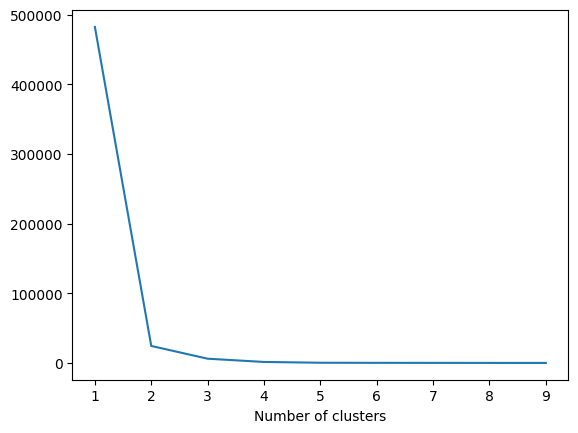

In [107]:
# Use elbow method to find the optimal number of clusters for frequency
sse = {}

frequency = customer_segmentation[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [108]:
# Apply k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_segmentation[['Frequency']])
customer_segmentation['FrequencyCluster'] = kmeans.predict(customer_segmentation[['Frequency']])
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12431.0,20,2,186,0
1,12386.0,321,1,10,2
2,12434.0,68,0,54,2
3,12415.0,8,2,778,1
4,12393.0,56,0,64,2


## Revenue

In [109]:
# Calculate revenue for each customer
customer_aus['Revenue'] = customer_aus['UnitPrice'] * customer_aus['Quantity']
revenue = customer_aus.groupby('CustomerID').Revenue.sum().reset_index()
revenue.head()

,CustomerID,Revenue
0,12386.0,401.90
1,12388.0,2780.66
2,12393.0,1582.60
3,12415.0,123725.45
4,12422.0,386.20


In [110]:
# Merge the dataframes
customer_segmentation = pd.merge(customer_segmentation, revenue, on='CustomerID')
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,12431.0,20,2,186,0,5443.61
1,12386.0,321,1,10,2,401.90
2,12434.0,68,0,54,2,765.19
3,12415.0,8,2,778,1,123725.45
4,12393.0,56,0,64,2,1582.60


C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\1611439686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue["clusters"] = kmeans.labels_
C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\1611439686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue["clusters"] = kmeans.labels_
C:\Users\Langat Kevin\AppData\Local\Temp\ipykernel_3976\1611439686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

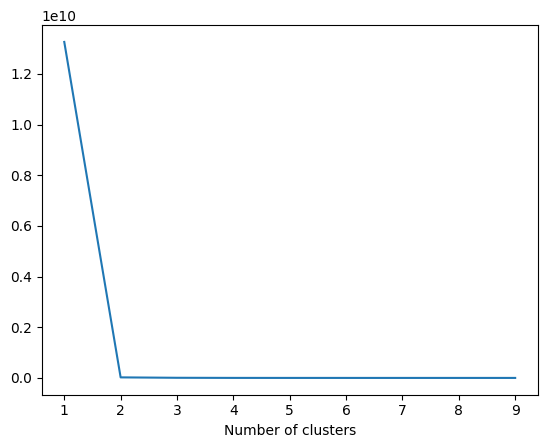

In [111]:
# Use elbow method to find the optimal number of clusters for revenue
sse = {}

revenue = customer_segmentation[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

### Revenue Clusters

In [112]:
# Apply k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_segmentation[['Revenue']])
customer_segmentation['RevenueCluster'] = kmeans.predict(customer_segmentation[['Revenue']])
customer_segmentation = order_cluster('RevenueCluster', 'Revenue', customer_segmentation, True)


customer_segmentation.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5.0,673.318,544.804871,230.70,386.20,401.90,765.190,1582.60
1,3.0,3328.410,1901.446897,1760.96,2270.81,2780.66,4112.135,5443.61
2,1.0,123725.450,NaN,123725.45,123725.45,123725.45,123725.450,123725.45


## Overall Score based on RFM Clustering

In [113]:
# Calculate the overall score and use mean() to see the details
customer_segmentation['OverallScore'] = customer_segmentation['RecencyCluster'] + customer_segmentation['FrequencyCluster'] + customer_segmentation['RevenueCluster']
customer_segmentation.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
2,65.0,38.75,741.1725
3,122.0,81.50,2596.7825
5,8.0,778.00,123725.4500


Best Customer = Score 5
Worst Customer = Score 0

In [114]:
customer_segmentation['Segment'] = 'Low-Value'
customer_segmentation.loc[customer_segmentation['OverallScore'] > 2, 'Segment'] = 'Mid-Value'
customer_segmentation.loc[customer_segmentation['OverallScore'] > 4, 'Segment'] = 'High-Value'
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12431.0,20,2,186,0,5443.61,1,3,Mid-Value
1,12388.0,0,2,100,0,2780.66,1,3,Mid-Value
2,12424.0,147,0,30,2,1760.96,1,3,Mid-Value
3,12386.0,321,1,10,2,401.90,0,3,Mid-Value
4,12434.0,68,0,54,2,765.19,0,2,Low-Value


## Customer Lifetime Value
Calculate 6 months LTV for each customer then use it for training the model

**Lifetime Value = Total Gross Revenue - Total Cost**

Use revenue as LTV directly

In [115]:
customer_aus["InvoiceDate"].describe()

count                             1259
mean     2011-06-08 16:28:46.465448704
min                2010-12-01 10:03:00
25%                2011-03-03 10:59:00
50%                2011-06-15 13:37:00
75%                2011-08-18 08:51:00
max                2011-11-24 12:30:00
Name: InvoiceDate, dtype: object

Customers were active since December 1, 2010. Consider customers from March onwards (not new customers). Divide them into 2 subgroups. From the two groups, analyse 3 months time frame and 6 months timeframe.

In [116]:
customer_3m = customer_aus[(customer_aus.InvoiceDate < datetime(2011, 6, 1)) & (customer_aus.InvoiceDate >= datetime(2011, 3, 1))].reset_index(drop=True) # 3 months
customer_6m = customer_aus[(customer_aus.InvoiceDate >= datetime(2011, 6, 1)) & (customer_aus.InvoiceDate < datetime(2011, 12, 1))].reset_index(drop=True) # 6 months

In [117]:
# Calculate revenue and create new dataframe for each 6 months
customer_6m['Revenue'] = customer_6m['UnitPrice'] * customer_6m['Quantity']
customer_6m = customer_6m.groupby('CustomerID').Revenue.sum().reset_index()
customer_6m.columns = ['CustomerID', 'Revenue_6m']
customer_6m.head()


,CustomerID,Revenue_6m
0,12388.0,2014.41
1,12393.0,521.50
2,12415.0,73435.25
3,12422.0,147.70
4,12424.0,1760.96


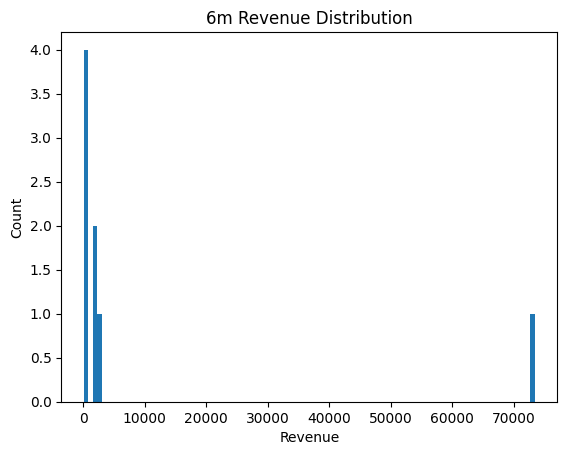

In [118]:
# Plot the distribution of revenue
plt.hist(customer_6m['Revenue_6m'], bins=100)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title('6m Revenue Distribution')
plt.show()

There's outliers

In [119]:
customer_segmentation.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12431.0,20,2,186,0,5443.61,1,3,Mid-Value
1,12388.0,0,2,100,0,2780.66,1,3,Mid-Value
2,12424.0,147,0,30,2,1760.96,1,3,Mid-Value
3,12386.0,321,1,10,2,401.90,0,3,Mid-Value
4,12434.0,68,0,54,2,765.19,0,2,Low-Value


In [120]:
customer_aus.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia,201012,51.0
1,198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia,201012,39.6
2,199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia,201012,15.0
3,200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia,201012,32.7
4,201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,2010-12-01 10:03:00,6.35,12431.0,Australia,201012,25.4


In [127]:
# Merge the dataframes
customer_merged = pd.merge(customer_segmentation, customer_6m, on='CustomerID', how='left')
customer_merged = customer_merged.fillna(0)
customer_merged.head()  

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m
0,12431.0,20,2,186,0,5443.61,1,3,Mid-Value,2935.08
1,12388.0,0,2,100,0,2780.66,1,3,Mid-Value,2014.41
2,12424.0,147,0,30,2,1760.96,1,3,Mid-Value,1760.96
3,12386.0,321,1,10,2,401.90,0,3,Mid-Value,0.00
4,12434.0,68,0,54,2,765.19,0,2,Low-Value,519.89


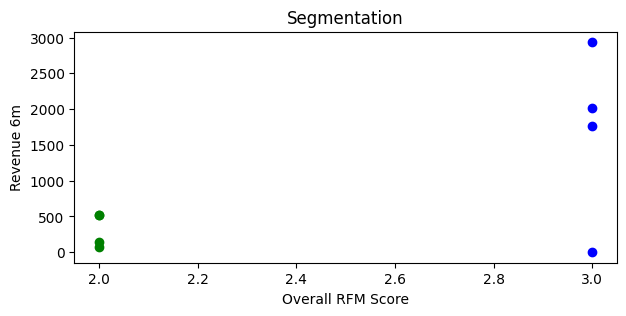

In [139]:
# plot a scatter plot of RFM scores (Recency, Frequency, and Monetary) against Revenue for different customer segments(Low-Value, Mid-Value, High-Value).
plt.figure(figsize=(7, 3))
plt.scatter(customer_merged.query("Segment == 'Low-Value'")['OverallScore'], customer_merged.query("Segment == 'Low-Value'")['Revenue_6m'], color='g')
plt.scatter(customer_merged.query("Segment == 'Mid-Value'")['OverallScore'], customer_merged.query("Segment == 'Mid-Value'")['Revenue_6m'], color='b')
plt.scatter(customer_merged.query("Segment == 'High-Value'")['OverallScore'], customer_merged.query("Segment == 'High-Value'")['Revenue_6m'], color='r')
plt.xlabel('Overall RFM Score')
plt.ylabel('Revenue 6m')
plt.title('Segmentation')
plt.show()

In [128]:
# Remove outliers
customer_merged = customer_merged[customer_merged['Revenue_6m'] < customer_merged['Revenue_6m'].quantile(0.99)]
customer_merged.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m
0,12431.0,20,2,186,0,5443.61,1,3,Mid-Value,2935.08
1,12388.0,0,2,100,0,2780.66,1,3,Mid-Value,2014.41
2,12424.0,147,0,30,2,1760.96,1,3,Mid-Value,1760.96
3,12386.0,321,1,10,2,401.90,0,3,Mid-Value,0.00
4,12434.0,68,0,54,2,765.19,0,2,Low-Value,519.89


In [142]:
# Create 3 clusters and order them
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_merged[['Revenue_6m']])
customer_merged['LTVCluster'] = kmeans.predict(customer_merged[['Revenue_6m']])
customer_merged = order_cluster('LTVCluster', 'Revenue_6m', customer_merged, True)
customer_merged.groupby('LTVCluster')['Revenue_6m'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,5.0,252.818,250.051718,0.00,75.0000,147.700,519.8900,521.50
1,2.0,1887.685,179.216214,1760.96,1824.3225,1887.685,1951.0475,2014.41
2,1.0,2935.080,NaN,2935.08,2935.0800,2935.080,2935.0800,2935.08


In [144]:
customer_cluster = customer_merged.copy()
customer_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m,RevenueCluster_6m,LTVCluster
0,12431.0,20,2,186,0,5443.61,1,3,Mid-Value,2935.08,2,2
1,12388.0,0,2,100,0,2780.66,1,3,Mid-Value,2014.41,2,1
2,12424.0,147,0,30,2,1760.96,1,3,Mid-Value,1760.96,2,1
3,12386.0,321,1,10,2,401.90,0,3,Mid-Value,0.00,0,0
4,12422.0,80,0,21,2,386.20,0,2,Low-Value,147.70,0,0


In [145]:
# Convert categorical columns to numerical
customer_class = pd.get_dummies(customer_cluster)
customer_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Revenue_6m,RevenueCluster_6m,LTVCluster,Segment_Low-Value,Segment_Mid-Value
0,12431.0,20,2,186,0,5443.61,1,3,2935.08,2,2,False,True
1,12388.0,0,2,100,0,2780.66,1,3,2014.41,2,1,False,True
2,12424.0,147,0,30,2,1760.96,1,3,1760.96,2,1,False,True
3,12386.0,321,1,10,2,401.90,0,3,0.00,0,0,False,True
4,12422.0,80,0,21,2,386.20,0,2,147.70,0,0,True,False


In [146]:
# Calculate the correlation matrix
corr = customer_class.corr()
corr['LTVCluster'].sort_values(ascending=False)

LTVCluster           1.000000
Revenue_6m           0.976489
Revenue              0.940880
RevenueCluster       0.912871
Frequency            0.837301
RevenueCluster_6m    0.816497
RecencyCluster       0.721995
OverallScore         0.707107
Segment_Mid-Value    0.707107
CustomerID          -0.263211
Recency             -0.347471
Segment_Low-Value   -0.707107
FrequencyCluster    -0.816497
Name: LTVCluster, dtype: float64

In [147]:
#Create X and y variables, X will be feature set and y is the label - LTV
X = customer_class.drop(['LTVCluster', 'Revenue_6m'], axis=1)
y = customer_class['LTVCluster']

# Split the data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## ML model for Customer Lifetime Value Prediction

In [149]:
# XGBoost Multiclassification Model
ltv_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_jobs = -1)

# Fit the model
ltv_model.fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}".format(ltv_model.score(X_test, y_test)))
print("Accuracy of XGB classifier on test set: {:.2f}".format(ltv_model.score(X_test, y_test)))

y_pred = ltv_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.50
Accuracy of XGB classifier on test set: 0.50


In [152]:
# Check the precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\Langat Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Langat Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Langat Kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

